# Background

This notebook demonstrates a single model that combines paid and reported (incurred) losses, ensuring they converge to the same ultimate value. We refer to this as the joint model, as it models paid and reported losses jointly while enforcing their convergence to a same ultimate loss. This is achieved by conditioning the baseline models to being equal on the final development age losses. 

In [1]:
import torch as pt
import pyro.distributions as dist
import pyro
from pyro.infer.reparam import SplitReparam
from matplotlib import pyplot as plt

# To avoid "OMP: Error #15: Initializing libiomp5md.dll, but found libiomp5md.dll already initialized." error.
# Should be fine in most cases, but if you encounter issues related to this, please remove this line and fix your installation.
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

# Definitions

The baseline models are defined using the per development age means and standard deviations of the loss development factors. Note that the first values is an actual loss value, and not a loss development.

In [2]:
paid_loss_development_factor_mean = pt.Tensor([0.3, 3.0, 1.8, 1.2, 1.1])
paid_loss_development_factor_std  = pt.Tensor([2.0, 2.0, 1.0, 0.2, 0.1])
reported_loss_development_factor_mean = pt.Tensor([0.6, 1.3, 1.2, 1.1, 1.03])
reported_loss_development_factor_std  = pt.Tensor([0.1, 0.2, 0.1, 0.05, 0.02])

We now figure out the parameters of the log-normal distribution of the loss development factors.

In [3]:
def log_normal_z_params(mu, sigma):
    mu_squared = mu * mu
    sigma_squared = sigma * sigma
    return pt.log(mu_squared / pt.sqrt(mu_squared + sigma_squared)), \
           pt.sqrt(pt.log(1 + sigma_squared / mu_squared))

paid_loss_development_factor_mu, paid_loss_development_factor_sigma = \
    log_normal_z_params(paid_loss_development_factor_mean,paid_loss_development_factor_std)
reported_loss_development_factor_mu, reported_loss_development_factor_sigma = \
    log_normal_z_params(reported_loss_development_factor_mean, reported_loss_development_factor_std)

Below is a definition of the transformation which converts loss development factors into the cumulative loss.

In [4]:
class CumSumTransform(dist.transforms.Transform):
    domain = dist.constraints.independent(dist.constraints.real, 1)
    codomain = dist.constraints.independent(dist.constraints.real, 1)
    bijective = True

    def log_abs_det_jacobian(self, x, y):
        return x.new_zeros(x.shape[:(-1)])

    def _call(self, x):
        return x.cumsum(dim=-1)

    def _inverse(self, x):
        return pt.diff(x, prepend=x.new_zeros(x.shape[:-1] +(1,)))

Let's define our loss distributions.

In [5]:
# Loss development distributions
paid_loss_development_factor_dist = dist.Normal(paid_loss_development_factor_mu, paid_loss_development_factor_sigma)
reported_loss_development_factor_dist = dist.Normal(reported_loss_development_factor_mu, reported_loss_development_factor_sigma)

# Cumulative loss distributions
paid_loss_dist = dist.TransformedDistribution(paid_loss_development_factor_dist,
                                                  [CumSumTransform(), dist.transforms.ExpTransform()])
reported_loss_dist = dist.TransformedDistribution(reported_loss_development_factor_dist,
                                                  [CumSumTransform(), dist.transforms.ExpTransform()])

# Baseline model

In [6]:
def base_model():
    paid_loss = pyro.sample("paid_loss", paid_loss_dist)
    reported_loss = pyro.sample("reported_loss", reported_loss_dist)
    return paid_loss, reported_loss

We use Stochastic Variational Inference (SVI) to approximate the distribution of the baseline model. While SVI isn’t required for the baseline model itself, it will be needed later for the joint model.

In [7]:
def fit(model, num_steps=2001, lr=0.03):
    pyro.clear_param_store()
    guide = pyro.infer.autoguide.AutoMultivariateNormal(model)
    # Setup ELBO and optimizer
    elbo = pyro.infer.JitTrace_ELBO(vectorize_particles=True, num_particles=100, ignore_jit_warnings=True)
    elbo.loss(model, guide)
    optim = pyro.optim.Adam({"lr": lr})
    svi = pyro.infer.SVI(model, guide, optim, loss=elbo)

    # optimize
    for i in range(num_steps):
        loss = svi.step()
        if i % 400 == 0:
            print(f"step {i} loss = {loss:0.6g}")

    return guide

base_guide = fit(base_model)


INFO 	 Guessed max_plate_nesting = 1


step 0 loss = 52.8624
step 400 loss = 1.53874
step 800 loss = 0.811566
step 1200 loss = 0.679534
step 1600 loss = 0.373664
step 2000 loss = 0.395901


Let's sample and plot the baseline model.

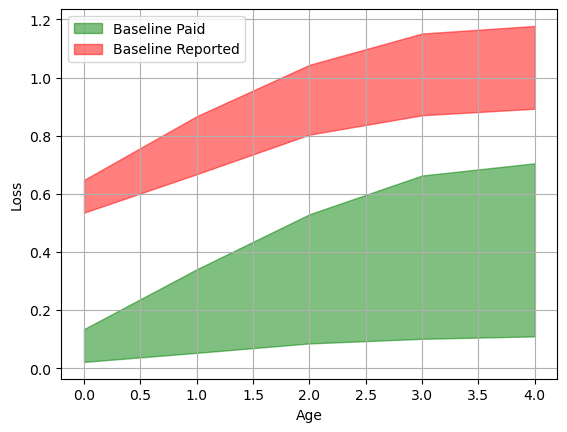

In [8]:
base_samples = pyro.infer.WeighedPredictive(base_model, guide=base_guide, num_samples=10000,
                                            parallel=True, return_sites=["paid_loss", "reported_loss"])()

lower_percentile = 0.25
upper_percentile = 0.75

def plot_ci(samples, **kwargs):
    lower, upper = pyro.ops.stats.quantile(samples, [lower_percentile, upper_percentile])
    plt.fill_between(range(samples.shape[-1]), lower, upper, **kwargs)

plot_ci(base_samples.samples["paid_loss"], alpha=0.5, label="Baseline Paid", color="g")
plot_ci(base_samples.samples["reported_loss"], alpha=0.5, label="Baseline Reported", color="r")
plt.legend(loc="upper left")
plt.xlabel("Age")
plt.ylabel("Loss")
plt.grid()

We can observe that the last age paid and reported losses are not the same, as they have different distributions.

# Joint model

The joint model is derived from the baseline model by conditioning it, requiring that the last age paid and reported losses are the same.

In [9]:
# Split last loss
split_reparam = SplitReparam([len(paid_loss_development_factor_mu) - 1, 1], -1)
split_model = pyro.poutine.reparam(base_model, dict(paid_loss=split_reparam, reported_loss=split_reparam))
# Equalize last loss
same_ultimate_model = pyro.poutine.equalize(split_model, ["paid_loss_split_1", "reported_loss_split_1"])
same_ultimate_guide = fit(same_ultimate_model)

INFO 	 Guessed max_plate_nesting = 1


step 0 loss = 53.4682
step 400 loss = 2.93021
step 800 loss = 2.41435
step 1200 loss = 2.23689
step 1600 loss = 2.33222
step 2000 loss = 1.93883


Let's sample the joint model and plot the loss distributions.

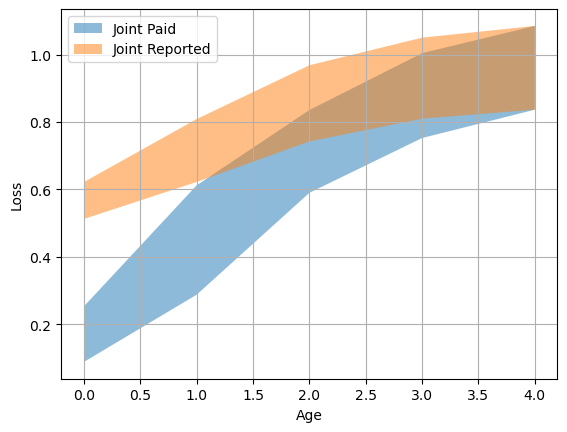

In [10]:
same_ultimate_samples = pyro.infer.WeighedPredictive(same_ultimate_model, guide=same_ultimate_guide, num_samples=10000,
                                                     parallel=True, return_sites=["paid_loss", "reported_loss"])()

plot_ci(same_ultimate_samples.samples["paid_loss"], alpha=0.5, label="Joint Paid")
plot_ci(same_ultimate_samples.samples["reported_loss"], alpha=0.5, label="Joint Reported")
plt.legend(loc="upper left")
plt.xlabel("Age")
plt.ylabel("Loss")
plt.grid()

We can see how the conditioning of the model changed the loss distributions. Now the last age paid and reported losses have the same distribution, and they are in fact identical (you can look at the samples in order to verify this).

We can now look at all four distributions to see how the conditioning has changed the original distribution.

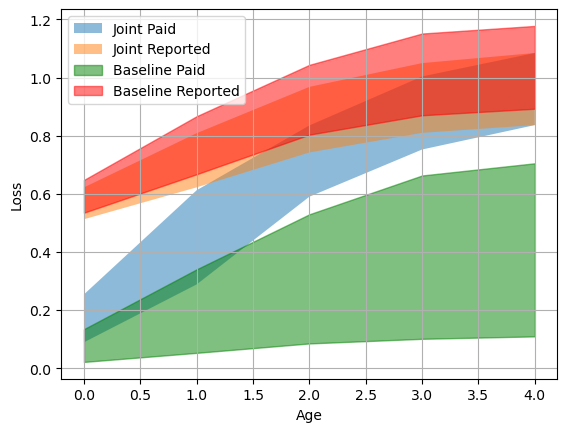

In [11]:
plot_ci(same_ultimate_samples.samples["paid_loss"], alpha=0.5, label="Joint Paid")
plot_ci(same_ultimate_samples.samples["reported_loss"], alpha=0.5, label="Joint Reported")
plot_ci(base_samples.samples["paid_loss"], alpha=0.5, label="Baseline Paid", color="g")
plot_ci(base_samples.samples["reported_loss"], alpha=0.5, label="Baseline Reported", color="r")
plt.legend(loc="upper left")
plt.xlabel("Age")
plt.ylabel("Loss")
plt.grid()

Notice how the confidence interval of the joint model’s paid losses becomes narrower starting from the second development age onward.